In [175]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

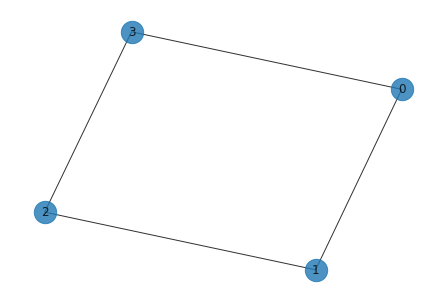

In [176]:
# EXAMPLE GRAPH
w_example = np.array(
    [[0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]]
)
G_example = nx.from_numpy_matrix(w_example)
my_pos = nx.spring_layout(G_example, seed=0)
nx.draw(G_example, my_pos, with_labels=True, alpha=0.8, node_size=500)

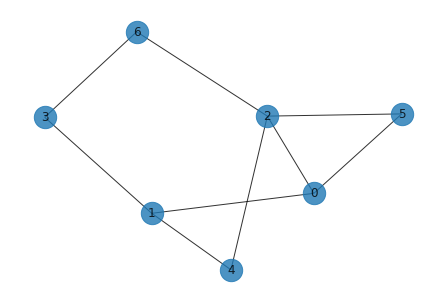

In [189]:
# CREATE OUR GRAPH
w = np.array( # Unweighted graph
    [[0, 1, 1, 0, 0, 1, 0],
    [1, 0, 0, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0]])
G = nx.from_numpy_matrix(w)
my_pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos=my_pos, with_labels=True, alpha=0.8, node_size=500)

In [178]:
from qiskit.opflow import I, X, Y, Z

"""
Create a matrix of zeros (that we will later use for H_P)
"""
def create_zero_hamiltonian(graph):
    zero_H = Z-Z
    result = zero_H
    for i in range(graph.number_of_nodes()-1):
        result = result ^ zero_H
    return result
"""
Create the max-cut problem hamiltonian H_P from a graph
"""
def create_problem_hamiltonian(graph):
    nqubits = graph.number_of_nodes()
    H = create_zero_hamiltonian(graph) # set initial Hamiltonian to 1
    for (i,j) in graph.edges():
        tempH = 1 # Second term of the inner sum
        for k in range(nqubits):
            if k == i or k == j:
                tempH = tempH ^ Z
            else:
                tempH = tempH ^ I
        H += tempH
    return H

In [ ]:
# Cell copied from https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html
from collections import OrderedDict
from qiskit.utils import algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.opflow import StateFn
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.runtime import QAOAClient

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

In [192]:
from qiskit import IBMQ
from qiskit_optimization.runtime import QAOAClient

algorithm_globals.random_seed = 10598
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_qasm_simulator') # Run on a simulator
backend = provider.get_backend("ibm_kawasaki") # Run on a real device

qaoa = QAOAClient(optimizer=COBYLA(), provider=provider, backend=backend, reps=5)

ibmqfactory.load_account:WARNING:2022-12-07 16:08:49,371: Credentials are already in use. The existing account in the session will be replaced.


In [193]:
# Create the problem Hamiltonian using our previously defined function
input_graph = G_example # Change this to G if we want to run on the bigger graph
problem_hamiltonian = create_problem_hamiltonian(input_graph)
print(problem_hamiltonian)

0.0 * ZZZZ
+ 1.0 * ZZII
+ 1.0 * ZIIZ
+ 1.0 * IZZI
+ 1.0 * IIZZ


In [ ]:
# Get the vector with the lowest eigenvalue
result = qaoa.compute_minimum_eigenvalue(problem_hamiltonian)

maxcut = list(sample_most_likely(result.eigenstate))[::-1]

print(str(maxcut))

In [187]:
"""
Compute the value of a particular cut
"""
def get_cut_value(graph, cut):
    cut_value = 0
    for (v1, v2) in graph.edges():
        cut_value += abs(cut[v1]-cut[v2])
    return cut_value
print("Cut value: " + str(get_cut_value(input_graph, maxcut)))

Cut value: 4


[1, 0, 1, 0]


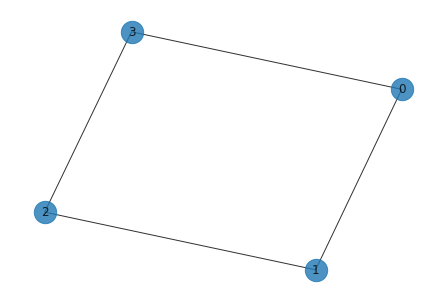

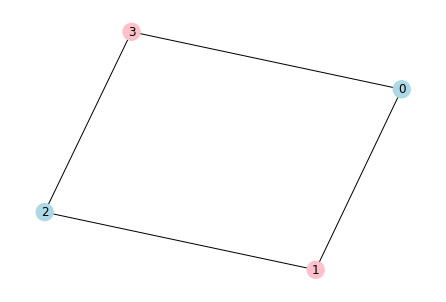

In [190]:
"""
Draw our graph (both uncut and cut) and print the cut
"""
def draw_cut_graph(graph, cut):
    color_map = []
    for node in range(len(graph.nodes)):
        if cut[node] == 0:
            color_map.append('pink')
        else: 
            color_map.append('lightblue')
    my_pos = nx.spring_layout(graph, seed = 0)

    plt.figure(1)
    nx.draw(graph, pos=my_pos, with_labels=True, alpha=0.8, node_size=500)
    plt.figure(2)
    nx.draw(graph, pos=my_pos, node_color=color_map, with_labels=True)
print(maxcut)
draw_cut_graph(input_graph, maxcut)